In [1]:
from scipy.integrate import quad, trapz, fixed_quad
import theano
import theano.tensor as T
from theano.tests.unittest_tools import verify_grad
from theano.compile.ops import as_op

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

import astropy.units as u

from tqdm import tqdm

from gammapy.spectrum import CountsPredictor, CountsSpectrum

from utils import load_spectrum_observations, plot_spectra, Log10Parabola, integrate_spectrum, wstat_profile
from forward_fold_model import model_probability, ln_profile_likelihood

%matplotlib inline

In [2]:
theano.config.floatX ='float32'
# print(theano.config)
class Integrate(theano.Op):
    def __init__(self, expr, var, lower, upper, *inputs):
        super().__init__()
        self._expr = expr
        self._var = var
        self._extra_vars = inputs
        self.lower = lower
        self.upper = upper
        self._func = theano.function(
            [var] + list(self._extra_vars),
            self._expr,
            on_unused_input='ignore'
        )
    
    def make_node(self, *inputs):
        assert len(self._extra_vars)  == len(inputs)
        return theano.Apply(self, list(inputs), [T.dscalar().type()])
    
    def perform(self, node, inputs, out):
        x = np.linspace(self.lower, self.upper, num=3)
        y = np.array([self._func(i , *inputs) for i in x])
        val = trapz(y, x)
#         print(val)
#         val = quad(self._func, self.lower, self.upper, args=tuple(inputs))[0]
        out[0][0] = np.array(val)
        
    def grad(self, inputs, grads):
        out, = grads
        grads = T.grad(self._expr, self._extra_vars)
        dargs = []
        for grad in grads:
            integrate = Integrate(grad, self._var, self.lower, self.upper, *self._extra_vars)
            darg = out * integrate(*inputs)
            dargs.append(darg)
            
        return dargs

In [3]:
def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to(u.TeV).value, fit_range.to(u.TeV).value )
    return [a[idx[0]:idx[1]] for a in arr]

In [4]:
def forward_fold_log_parabola_symbolic_no_units(amplitude, alpha, beta, e_true_lo, e_true_hi, selected_bin_ids, aeff, livetime, edisp, observation):
    amplitude *= 1e-11
    
    energy = T.dscalar('energy')
    amplitude_ = T.dscalar('amplitude_')
    alpha_ = T.dscalar('alpha_')
    beta_ = T.dscalar('beta_')

    func = amplitude_ * energy **(-alpha_ - beta_ * T.log10(energy))
    
    counts = []
    for a, b in zip(e_true_lo, e_true_hi):
        c = Integrate(func, energy, a, b, amplitude_, alpha_, beta_)(amplitude, alpha, beta)
        counts.append(c)

    counts = T.stack(counts)
    aeff = aeff
    

    counts *= aeff
    counts *= livetime
    edisp = edisp
    
    idx = selected_bin_ids
    return T.dot(counts, edisp)[idx[0]:idx[1]]

    return T.dot(counts, edisp)

In [6]:
obs_list, fit_range = load_spectrum_observations('fact')
observation = obs_list[0]
energy_bins = observation.on_vector.energy.bins

In [7]:
def wstat_model_symbolic(mu_sig, observation, fit_range):
    on_data = observation.on_vector.data.data.value
    off_data = observation.off_vector.data.data.value
    mu_sig, on_data, off_data, obs_alpha = apply_range(mu_sig, on_data, off_data, observation.alpha, fit_range=fit_range, bins=energy_bins)
    
    p = ln_profile_likelihood(mu_sig, on_data, off_data, alpha=obs_alpha)
    p = -0.5*sum(p)
    return p, mu_sig

In [13]:
amplitude = T.dscalar('amplitude')
alpha = T.dscalar('alpha')
beta = T.dscalar('beta')

e_true_lo = observation.edisp.e_true.lo.to_value(u.TeV)
e_true_hi = observation.edisp.e_true.hi.to_value(u.TeV)

obs_bins = observation.on_vector.energy.bins.to_value(u.TeV)
idx = np.searchsorted(obs_bins, fit_range.to_value(u.TeV))

aeff = observation.aeff.data.data.to_value(u.cm**2).astype(np.float32)
livetime = observation.livetime.to_value(u.s)

edisp = observation.edisp.pdf_matrix

cf_fast = forward_fold_log_parabola_symbolic_no_units(amplitude, alpha, beta, e_true_lo, e_true_hi, idx, aeff, livetime, edisp,  observation)
counts_symbolic = cf_fast.eval({amplitude: 4.0, alpha: 2.0, beta: 0.5})
counts_symbolic

array([ 14.43495154,  27.04655649,  47.84444291,  77.51652874,
       113.07310397, 148.02603571, 175.69779208, 192.17196395,
       196.82898682, 191.10613038, 177.20977592, 158.1373168 ,
       137.41158441, 117.66933262,  99.97265991,  84.15327835,
        70.03711709,  57.52210387,  46.85345858,  37.94003013,
        30.52036699,  24.22927885,  18.91720379,  14.50065326,
        10.90732126,   8.07117856,   5.85499554,   4.11747632,
         2.70923866,   1.57945828])

In [18]:
on_data = observation.on_vector.data.data.value
off_data = observation.off_vector.data.data.value
    
on_data, off_data, obs_alpha = apply_range(on_data, off_data, observation.alpha, fit_range=fit_range, bins=energy_bins)

exposure_ratio = observation.alpha[0]
   
e_true_lo = observation.edisp.e_true.lo.to_value(u.TeV)
e_true_hi = observation.edisp.e_true.hi.to_value(u.TeV)

obs_bins = observation.on_vector.energy.bins.to_value(u.TeV)
idx = np.searchsorted(obs_bins, fit_range.to_value(u.TeV))

aeff = observation.aeff.data.data.to_value(u.cm**2).astype(np.float32)
livetime = observation.livetime.to_value(u.s)

edisp = observation.edisp.pdf_matrix

model = pm.Model(theano_config={'compute_test_value': 'ignore'})
with model:

    amplitude = pm.TruncatedNormal('amplitude', mu=4, sd=0.5, lower=0, testval=4)
    alpha = pm.TruncatedNormal('alpha', mu=2.5, sd=0.5, lower=0, testval=2.5)
    beta = pm.TruncatedNormal('beta', mu=0.5, sd=0.5, lower=0, testval=0.5)
    
#     amplitude = pm.HalfFlat('amplitude',testval=4)
#     alpha = pm.HalfFlat('alpha', testval=2.5)
#     beta = pm.HalfFlat('beta', testval=0.5)
    
    mu_s = forward_fold_log_parabola_symbolic_no_units(amplitude, alpha, beta, e_true_lo, e_true_hi, idx, aeff, livetime, edisp,  observation)

#     mu_b = pm.HalfFlat('mu_b', shape=len(off_data))
#     mu_b = pm.TruncatedNormal('mu_b', mu=off_data, sd=5, shape=len(off_data), lower=0)
    mu_b  = pm.Deterministic('mu_b', calc_mu_b(mu_s, on_data, off_data, exposure_ratio), )
    b = pm.Poisson('background', mu=mu_b, observed=off_data, shape=len(off_data))    
    s = pm.Poisson('signal', mu=mu_s + exposure_ratio * mu_b, observed=on_data)

In [19]:
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

amplitude_lowerbound__ 1.160503
alpha_lowerbound__ 0.69049966
beta_lowerbound__ -0.74618477
background -89.10144213547215
signal -218.17929514649833


625it [00:07, 82.30it/s]


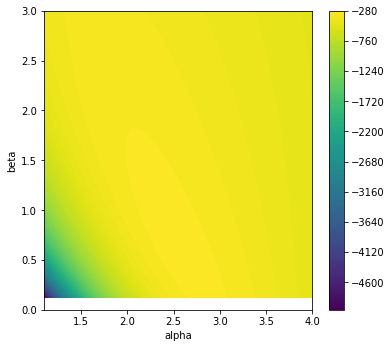

In [20]:
N = 25
betas = np.linspace(0, 3, N)
alphas = np.linspace(1.1, 4.0, N)
f = model.logp
zs = []
a, b = np.meshgrid(alphas, betas)
for al, be in tqdm(zip(a.ravel(), b.ravel())):
        
    p = f(amplitude_lowerbound__ = np.log(4), alpha_lowerbound__ = np.log(al), beta_lowerbound__= np.log(be),)
#     print(p)
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=124)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

In [21]:
map_estimate = pm.find_MAP(model=model)
map_estimate

logp = -298.26, ||grad|| = 3.0727: 100%|██████████| 18/18 [00:01<00:00,  9.50it/s]  


{'amplitude_lowerbound__': array(1.2515647, dtype=float32),
 'alpha_lowerbound__': array(0.9316984, dtype=float32),
 'beta_lowerbound__': array(-0.80649173, dtype=float32),
 'amplitude': array(3.4958086, dtype=float32),
 'alpha': array(2.5388174, dtype=float32),
 'beta': array(0.44642147, dtype=float32),
 'mu_b': array([   0.        ,    0.        ,   40.84346025,  829.6152674 ,
        1480.69792876, 1555.78871209, 1224.05364397, 1060.05124607,
         836.31892544,  607.06636151,  584.87306638,  374.87816716,
         273.97877978,  261.61043507,  192.19781843,  143.00613439,
          93.67721469,   87.54213935,   51.06802166,   66.33053294,
          36.86476814,   33.40928792,   32.97334386,   24.42005088,
          14.4       ,    5.14904314,    3.6       ,    7.2       ,
           0.        ,    0.        ])}

In [29]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(1500, init='auto', cores=8, step=[step]) # advi+adapt_diag

Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
>Metropolis: [amplitude]
Sampling 8 chains: 100%|██████████| 16000/16000 [04:53<00:00, 14.22draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd750ef6940>,
      dtype=object)

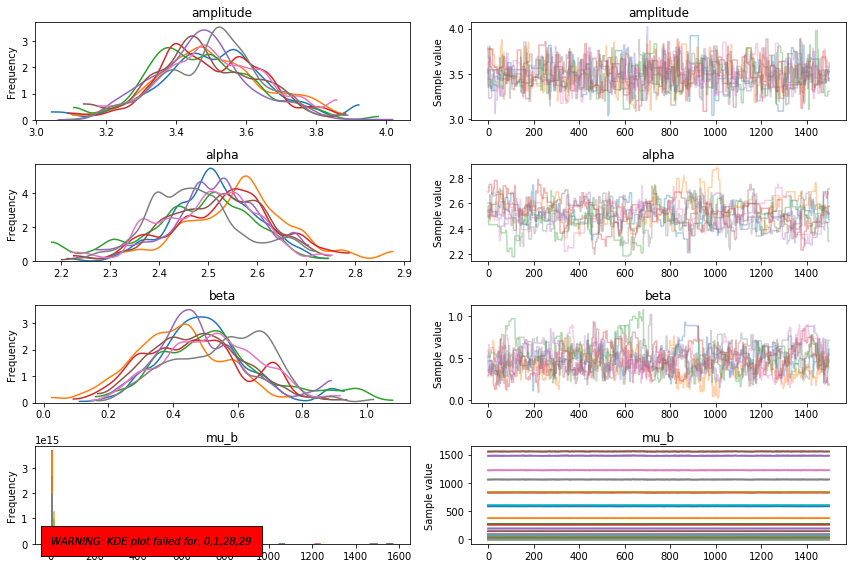

In [30]:
pm.traceplot(trace)